In [2]:
import numpy as np
import torch
from torch import nn
import sys
sys.path.append('../src')
from utils import compute_logD_list
from model import MLP
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import trange
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')


# Eep 12

In [7]:
data_len=1000
batch_size = 100
size=10
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(0,1),
    transforms.Resize(size=size),
])

train_data = datasets.CIFAR10(root = './data', train = True,
                        transform = transform, download = True)
train_data, _ = torch.utils.data.random_split(train_data, [data_len, 50000-data_len])

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True,pin_memory=True,num_workers=8)

Files already downloaded and verified


In [11]:
hidden_dim=size**2
depth=6
width_list=[hidden_dim for i in range(depth)]
width_list.append(10) #number of classes 
num_epochs=1000
model=MLP(width_list,p=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func=nn.CrossEntropyLoss()

In [12]:
tbar = trange(num_epochs, desc='Batch loss', leave=True)
model.train()
for epoch in tbar:
    batch_loss=0
    num_data=0
    for i ,(images,labels) in enumerate(train_loader):
        images= images.view(-1,size**2).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out= model(images)
        loss = loss_func(out[-1], labels)
        loss.backward()
        optimizer.step()
        batch_loss+=loss.item()*labels.numel()
        num_data+=labels.numel()
    batch_loss=batch_loss/num_data
    tbar.set_description("{:.2e}".format(batch_loss), refresh=True)
    if batch_loss<1e-3:
        break


8.50e-04:  15%|█▌        | 153/1000 [01:14<06:53,  2.05it/s]


In [15]:
batch_loss

0.0008503156393999233

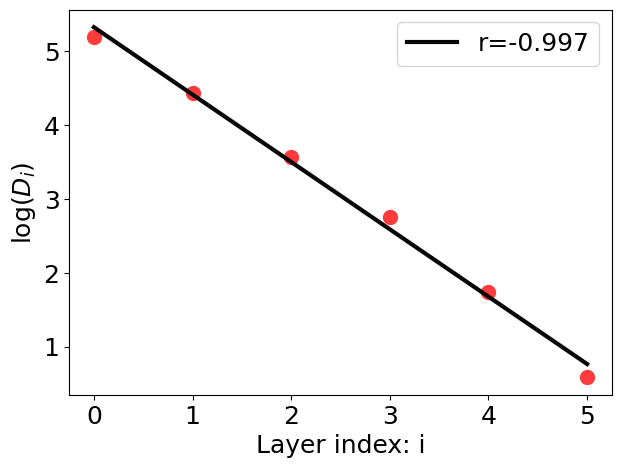

In [16]:
logD_list=compute_logD_list(model,train_loader,size,device)
logD_list=np.array(logD_list)
import matplotlib.pyplot as plt
from scipy import stats
color_list_two=[(7/255,7/255,7/255),(255/255,59/255,59/255)]
index_list=np.arange(len(logD_list))
slope, intercept, r_value, p_value, std_err = stats.linregress(index_list,logD_list)
r=stats.pearsonr(index_list,logD_list)[0]
x_0=[0,len(index_list)-1]
y_0=[intercept,intercept+(len(index_list)-1)*slope]
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams.update({'font.size': 18})
plt.plot(index_list,logD_list,'.',markersize=20,color=color_list_two[1])
plt.plot(x_0,y_0,'-',color=color_list_two[0],linewidth=3,label="r={:.3}".format(r))
plt.ylabel(r'$\log(D_i)$')
plt.legend()
plt.xlabel('Layer index: i')
plt.savefig('../figs/12.png',bbox_inches='tight')
plt.show()